<h1> Simulating Asset Price Evolutions and Reprice Risky up-and-out Call Option</h1>

<center><h3>Abstract</h3></center>
<br>
This report presents the results of the simulation of a European up-and-out call option over twelve months, but the difference between this submission and submission 1 is the implemen- tation of a non-constant interest rate and local volatility. We use LIBOR forward rate model to simulate interest rates. We also use discount factor to value the option without default risk and then the value of the option with counterparty default risk.
<br>
<br>

<h5> Keywords:</h5>
European Options, Non-constant interest rate, Local volatility, LIBOR forward rates, Zero-coupon bond and Stochastic Volatility.

# Introduction

In this paper, we go beyond the constant risk-free continuously-compounded rate. There are several models to implement stochastic interest rates. The short rate models which describe instantaneous continuously-compounded interest rate at time t,rt include the Vasicek model introduced in [1], Mamon in [2] advances this model by presenting approaches in obtaining the closed-form solution using the Vasicek model. Under the Vasicek model the short rate dynamics is given by,

$$dr_t = \alpha(b-r_t)dr + \sigma dW_t$$

where: \
$\sigma$ is the volatility of the short rate. 
$\alpha$ is the rate at which the short rate will tend towards $b$ \
$W_t$ is Brownian motion, \
$b$ is the level to which the short rate will tend in the long run,\



The stochastic differential equation can be solved to give $r_t$

$$r_t = e^{\alpha t} [r_0 +b(e^{\alpha t}-1) + \int_{0}^{t}\sigma e^{\alpha s} dW_t]$$


Cox, Ingersoll and Ross also presented a stochastic differential equation for short term rates in [4]
given by

$$dr_t = \alpha (b - r_t)dt + \sigma \sqrt{r_t} dW_t$$

This model prevents the short from becoming 0 but offers no closed form solution.

The Hull-White model described in [3] also presents stochastic differential equation for the short term rate,

$$dr_t = (\theta (t) -\alpha (t)r_t)dr_t + \sigma (t) dW_t$$

where $\theta (t) = \alpha b$ which is a non constant term, allowing the mean reversion level to vary.

The model we implement in this assignment is the LIBOR forward rate model to simulate interest rates. The initial values for the LIBOR forward rates need to be calibrated to the market forward rates which can be deduced through the market zero-coupon bond prices. This continuously compounded interest rate is given by,

$$e^{r_{ti}(t_{i+1}-t_{i})} = 1 + L(t_{i},t_{i+1})(t_{i+1}-t_{i})$$

Most of code implemented in this submission is derived from Module 6 [12] and Module 7 [13] of
the course.

We initialize most variables as given by the question.

- Option maturity is one year
- The option is struck at-the-money
- The current share price is USD 100
- The up-and-out barrier for the option is USD 150
- The risk-free continuously compounded interest rate is 8%
- The volatility for the underlying share is 30%
- The volatility for counterparty’s firm value is 25%
- The counterparty’s debt, due in one year, is USD 175
- The current firm value for the counterparty is $200
- The correlation between the counterparty and the stock is constant at 0.2 
- The recovery rate with the counterparty is 25%

# Part 1 : LIBOR Forward Rates, Stock Paths, and Counterparty Firm Values

In this part, we use a sample size of 100000, jointly simulate LIBOR forward rates, stock paths, and counterparty firm values. We assume that the counterparty firm and stock values are uncorrelated with LIBOR forward rates.

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import norm
import scipy.optimize

import math
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
### Initialize problem parameters
T = 1 # option maturity
L = 150 # up-and-out barrier
S0 = 100 # current share price
K = 100 # strike price, at-the-money


v_0 = 200 # counterparty firm current value
debt = 175 # counterparty's debt, due in one year 
corr = .2 # correlation
recovery_rate = 0.25 # recovery rate
########

corr_matrix = np.array([[1, corr], [corr, 1]])
sample_size = 1000000

In [3]:
sigma_const = 0.30
gamma = 0.75

##  Calibrate LIBOR forward rate model from zero coupon bond prices
We initialize the given zero-coupon bond prices:

In [4]:
# which gives monthly time intervals
t = np.linspace(0,1,13) 

market_zcb_prices = np.array([1.0, 0.9938, 0.9876, 0.9815, 0.9754, 0.9694, 0.9634, 0.9574, 0.9516,
       0.9457, 0.9399, 0.9342, 0.9285])

We next create functions to calculate the simulated bond prices from the Vasicek model (as well as helper functions A and D). We also define function F which is the differences between the bond prices calculated by our model and actual market zero-coupon bond prices:

In [5]:
def A(t1, t2, alpha):
    return (1 - np.exp(-alpha*(t2-t1)))/alpha

def D(t1, t2, alpha, b, sigma):
    val1 = (t2 - t1 - A(t1,t2,alpha)) * (sigma**2/(2 * alpha**2) - b)
    val2 = sigma**2 * A(t1,t2,alpha)**2 / (4*alpha)
    return val1-val2

def bond_price_fun(r,t,T, alpha, b, sigma):
    return np.exp(-A(t,T,alpha)*r + D(t,T,alpha,b,sigma))

def F(x):
    alpha = x[0]
    b = x[1]
    sigma = x[2]
    r0 = x[3]
    return sum( np.abs(bond_price_fun(r0,0,t,alpha,b,sigma) - market_zcb_prices))

scipy library provides fmin_slsqp method which looks for min value of provide function with Sequential Least Squares Programming method. In our case that would bring optimal model parameters which simulated market prices.

In [6]:
#minimizing F
bnds = ((0,1),(0,0.2),(0,0.2), (0.00,0.10))
opt_val = scipy.optimize.fmin_slsqp(F, (0.3, 0.05, 0.03, 0.05), bounds=bnds)
opt_alpha = opt_val[0]
opt_b = opt_val[1]
opt_sigma = opt_val[2]
opt_r0 = opt_val[3]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0002564991813429618
            Iterations: 10
            Function evaluations: 74
            Gradient evaluations: 10


fmin_slsqp - exit mode is 0 , which means optimization has found a solution. 

In [7]:
print("Optimal alpha: :%.3f" % opt_alpha)
print("Optimal b: %.3f" % opt_b)
print("Optimal sigma %.3f" % opt_sigma )
print("Optimal r0: %.3f" % opt_r0 )

Optimal alpha: :0.273
Optimal b: 0.069
Optimal sigma 0.028
Optimal r0: 0.075


We plot the actual market bond prices, with model-derived bond prices, and they look like a close fit.

In [8]:
%%capture output 
model_prices = bond_price_fun(opt_r0,0,t, opt_alpha, opt_b, opt_sigma)
model_yield = -np.log(model_prices) / t

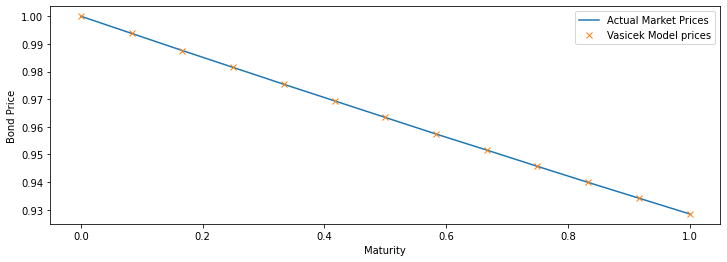

In [9]:
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(t, market_zcb_prices, label='Actual Market Prices')
ax.plot(t, model_prices, 'x', label='Vasicek Model prices')
plt.xlabel("Maturity")
plt.ylabel("Bond Price")
plt.legend()
plt.show()

We calculate forward rates based on prices of zero-coupon bonds.

##  Simulate LIBOR rate paths
We first initialize the parameter $\sigma_j$

In [10]:
sigmaj = 0.2

We use paramters we obtained above to recreate the Vasicek bond prices:

In [11]:
def A(t1, t2):
    return (1 - np.exp(-opt_alpha * (t2-t1)))/opt_alpha

def C(t1, t2):
    val1 = (t2 - t1 - A(t1,t2)) * (opt_sigma**2/ (2 * opt_alpha**2) - opt_b)
    val2 = opt_sigma**2 * A(t1,t2)**2 / (4 * opt_alpha)
    return val1 - val2

def bond_price(r,t,T):
    return np.exp( -A(t,T)*r + C(t,T))

vasi_bond = bond_price(opt_r0, 0, t)

The prices calculated from the Vasicek model are close to the ZCB prices given by the assignment as shown below:

In [12]:
print("Model zero coupon bond prices: ", vasi_bond)
print("Market zero coupon bond prices: ", market_zcb_prices)

Model zero coupon bond prices:  [1.         0.99377572 0.98760087 0.98147516 0.97539831 0.96936998
 0.96338983 0.95745752 0.95157266 0.94573489 0.93994381 0.93419901
 0.9285001 ]
Market zero coupon bond prices:  [1.     0.9938 0.9876 0.9815 0.9754 0.9694 0.9634 0.9574 0.9516 0.9457
 0.9399 0.9342 0.9285]


We now initialize the matrices we will use to store the Monte Carlo simulations, for both basic Monte Carlo and Predictor-Corrector method.

In [13]:
n_simulations = sample_size
n_steps = len(t)

mc_forward = np.ones([n_simulations, n_steps-1])*(vasi_bond[:-1]-vasi_bond[1:])/(vasi_bond[1:])
predcorr_forward = np.ones([n_simulations, n_steps-1])*(vasi_bond[:-1]-vasi_bond[1:])/(vasi_bond[1:])
predcorr_capfac = np.ones([n_simulations, n_steps])
mc_capfac = np.ones([n_simulations, n_steps])

delta = np.ones([n_simulations, n_steps - 1])*(t[1:]-t[:-1])

We now run the Monte Carlo simulation for each time step:

In [14]:
for i in range(1, n_steps):
    Z = norm.rvs(size=[n_simulations,1])
    
    muhat = np.cumsum(delta[:, i:] * mc_forward[:, i:] * sigmaj**2 \
                       /(1 + delta[:, i:] * mc_forward[:,i:]), axis=1)
    
    mc_forward[:,i:] = mc_forward[:,i:] * \
                            np.exp((muhat-sigmaj**2/2)*delta[:,i:]
                                       +sigmaj*np.sqrt(delta[:,i:]) * Z)
    
    mu_initial = np.cumsum(delta[:,i:]*predcorr_forward[:,i:]*sigmaj**2 \
                           /(1 + delta[:,i:] * predcorr_forward[:,i:]), axis=1)
    
    for_temp = predcorr_forward[:,i:] * \
                    np.exp((mu_initial - sigmaj**2 / 2) * delta[:,i:] \
                                  + sigmaj * np.sqrt(delta[:,i:]) * Z)
    
    mu_term = np.cumsum(delta[:,i:] * for_temp*sigmaj**2 \
                         /(1 + delta[:,i:] * for_temp), axis=1)
    
    predcorr_forward[:,i:] = predcorr_forward[:,i:] * \
                                np.exp((mu_initial + mu_term - sigmaj**2) * delta[:,i:]/2 \
                                                             + sigmaj * np.sqrt(delta[:,i:]) * Z)

Capitalization factors and bond prices are simulated using Monte Carlo simulation, later we plot them to compare  with the Vasicek bond prices.

In [15]:
mc_capfac[:,1:] = np.cumprod(1 + mc_forward, axis=1)
predcorr_capfac[:,1:] = np.cumprod(1 + predcorr_forward, axis=1)

mc_price = mc_capfac**(-1)
predcorr_price = predcorr_capfac**(-1)

mc_final = np.mean(mc_price, axis=0)
predcorr_final = np.mean(predcorr_price, axis=0)
predcorr_final

array([1.        , 0.99377572, 0.98760064, 0.98147463, 0.97539762,
       0.96936906, 0.96338885, 0.95745663, 0.951573  , 0.94573617,
       0.93994673, 0.93420439, 0.92850944])

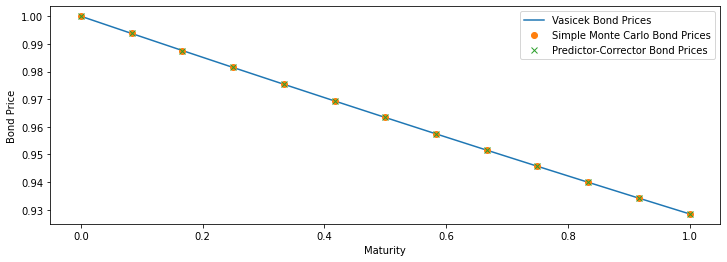

In [16]:
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(t,vasi_bond, label="Vasicek Bond Prices")
ax.plot(t, mc_final, 'o', label="Simple Monte Carlo Bond Prices")
ax.plot(t, predcorr_final, 'x', label="Predictor-Corrector Bond Prices")

plt.xlabel("Maturity")
plt.ylabel("Bond Price")
plt.legend()
plt.show()

In [17]:
model_forward_rates = (vasi_bond[:-1]-vasi_bond[1:])/ vasi_bond[1:]
pred_corr_forward_rates = np.mean(predcorr_forward, axis=0)

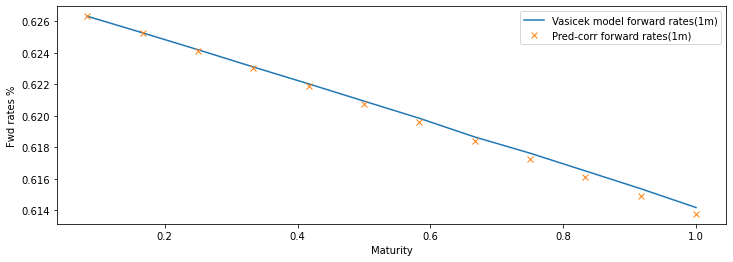

In [18]:
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(t[1:], pred_corr_forward_rates * 100, label='Vasicek model forward rates(1m)')
ax.plot(t[1:], model_forward_rates * 100, 'x', label='Pred-corr forward rates(1m)')

plt.xlabel("Maturity")
plt.ylabel("Fwd rates %")
plt.legend()
plt.show()

We calculate continuous compounded interest rates using Predictor-Corrector method from simulated forward rates
$$e^{r_{t_i} (t_{i+1}-t_i)} = 1 + L(t_i,t_{i+1})(t_{i+1}-t_i)$$

In [19]:
r_sim = np.log(1 + predcorr_forward*(delta))/delta
r_sim

array([[0.00626163, 0.00658869, 0.00658477, ..., 0.00799867, 0.00765505,
        0.00668731],
       [0.00626163, 0.00607795, 0.00611555, ..., 0.00597578, 0.00595966,
        0.00611528],
       [0.00626163, 0.00617499, 0.0067478 , ..., 0.00635871, 0.00647002,
        0.0064349 ],
       ...,
       [0.00626163, 0.0065521 , 0.00663733, ..., 0.00754359, 0.00740206,
        0.00763135],
       [0.00626163, 0.00622328, 0.00578683, ..., 0.0055275 , 0.00556709,
        0.00583721],
       [0.00626163, 0.00607882, 0.0054611 , ..., 0.00615593, 0.00651576,
        0.00606256]])

We also calculate an annualized form of the interest rates:

In [20]:
r_sim_annualized = pd.DataFrame(r_sim/delta)
r_sim_annualized

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.07514,0.079064,0.079017,0.080574,0.086160,0.084437,0.084815,0.083680,0.089538,0.095984,0.091861,0.080248
1,0.07514,0.072935,0.073387,0.067512,0.064631,0.068184,0.071333,0.066991,0.071194,0.071709,0.071516,0.073383
2,0.07514,0.074100,0.080974,0.074321,0.070622,0.073184,0.075824,0.072864,0.076297,0.076304,0.077640,0.077219
3,0.07514,0.084678,0.086495,0.091305,0.098394,0.090783,0.096371,0.083614,0.080779,0.088765,0.086017,0.084433
4,0.07514,0.077795,0.069153,0.067516,0.071534,0.077764,0.078352,0.079605,0.082018,0.087124,0.091889,0.097942
...,...,...,...,...,...,...,...,...,...,...,...,...
999995,0.07514,0.077995,0.084113,0.089499,0.098612,0.093692,0.094719,0.095490,0.094629,0.082334,0.078586,0.072662
999996,0.07514,0.070794,0.074949,0.073513,0.064961,0.066338,0.075103,0.076122,0.070845,0.070957,0.077137,0.077941
999997,0.07514,0.078625,0.079648,0.081293,0.088461,0.087001,0.087460,0.092320,0.093684,0.090523,0.088825,0.091576
999998,0.07514,0.074679,0.069442,0.064597,0.068704,0.067125,0.061619,0.066986,0.062987,0.066330,0.066805,0.070047


## Generate stock and firm values

Cholesky decomposition will provide correlate price paths with predifined correlation factor.

In [21]:
def next_share_price(prev_price, r, dT, sigma_const, gamma, sample_size, Z, varying_vol = True):

    if varying_vol:
        sigma = sigma_const*(prev_price)**(gamma-1)
    else:
        sigma = sigma_const*(S0)**(gamma-1)
    
    return prev_price*np.exp(np.cumsum((r-(sigma**2)/2)*(dT)+(sigma)*(np.sqrt(dT))*Z,1))

def generate_share_and_firm_price(S0, v_0, r_sim, sigma_const, gamma, corr, T, sample_size, timesteps = 12):
    corr_matrix = np.array([[1, corr], [corr, 1]])
    norm_matrix = stats.norm.rvs(size = np.array([sample_size, 2, timesteps]))
    corr_norm_matrix = np.matmul(np.linalg.cholesky(corr_matrix), norm_matrix)
    
    
    share_price_path = pd.DataFrame(
         next_share_price(S0, r_sim, 1/timesteps, sigma_const, gamma, sample_size, Z=corr_norm_matrix[:,0,]))
    share_price_path = share_price_path.transpose()
    
    first_row = pd.DataFrame([S0]*sample_size)
    first_row = first_row.transpose()
    share_price_path = pd.concat([first_row, share_price_path])
    share_price_path = share_price_path.reset_index(drop=True)

    firm_price_path = pd.DataFrame(
        next_share_price(v_0, r_sim, 1/timesteps, sigma_const, gamma, sample_size, Z=corr_norm_matrix[:,1,]))
    firm_price_path = firm_price_path.transpose()
    
    first_row = pd.DataFrame([v_0]*sample_size)
    first_row = first_row.transpose()
    firm_price_path = pd.concat([first_row, firm_price_path])
    firm_price_path = firm_price_path.reset_index(drop=True)

    return [share_price_path,firm_price_path]  

In [22]:
share_prices, firm_prices = generate_share_and_firm_price(S0, v_0, 
                                                          r_sim_annualized, 
                                                          sigma_const, 
                                                          gamma, 
                                                          corr, T, sample_size, timesteps = 12)

We then print out the share price and firm value paths:

In [23]:
share_prices

,0,1,2,3,4,5,6,7,8,9,...,999990,999991,999992,999993,999994,999995,999996,999997,999998,999999
0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
1,95.981557,94.975553,101.251044,105.017934,105.010377,99.724088,100.396460,99.655420,99.180517,100.334327,...,99.811914,101.454240,102.797735,102.281233,102.393414,108.785416,97.135349,96.044819,100.408214,103.277429
2,92.107931,94.575560,97.874478,110.006809,107.702609,101.564638,100.622611,102.544895,97.145510,97.139773,...,93.299618,103.182596,100.798444,106.384631,102.422706,109.075427,92.981566,99.657938,98.850375,108.803784
3,93.981213,95.072652,103.567918,114.471156,112.898698,96.981847,98.307235,100.091704,99.332268,98.603609,...,96.778093,106.368672,100.362241,106.282098,100.493628,110.987131,93.613009,100.109947,95.456612,105.999415
4,96.456355,94.083484,105.018267,113.697826,111.054563,95.635690,101.156566,97.781422,101.303382,101.408671,...,94.836703,104.981197,100.020808,105.248595,97.115476,105.941857,93.110455,102.363769,96.084187,110.184787
5,96.485585,97.424308,103.342601,116.423464,114.742007,96.039049,103.181109,98.867229,101.924293,104.513041,...,96.848297,102.594957,101.593156,110.127132,98.105552,108.725554,92.361783,100.403090,93.815165,107.509734
6,101.042844,95.704506,108.844059,117.210942,114.773714,93.745646,101.623586,102.379117,99.939920,101.177973,...,99.453372,102.677721,106.745242,108.089314,100.700495,111.306717,93.825955,98.269606,98.543715,115.842354
7,105.474136,90.565475,109.929152,117.776816,120.137288,101.313328,104.436452,107.200040,105.285743,109.119625,...,96.335368,103.378982,106.842943,106.986642,104.001263,106.929342,93.214579,98.321669,97.452261,109.485867
8,99.372644,86.807104,110.130611,123.026275,115.687579,102.200644,99.251224,104.253535,108.767275,109.789654,...,96.729251,99.290575,104.134768,101.184963,102.999930,110.886151,94.953691,99.860734,91.899564,106.943427
9,102.184139,89.880109,108.718906,122.035067,113.940857,97.800681,96.372815,105.210380,107.757413,111.200702,...,98.866448,101.332137,103.526172,105.192945,104.623288,115.811319,92.199655,97.220814,92.282538,104.828891


In [24]:
firm_prices

,0,1,2,3,4,5,6,7,8,9,...,999990,999991,999992,999993,999994,999995,999996,999997,999998,999999
0,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,...,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
1,196.016819,204.209285,209.968578,195.457087,202.166426,202.898722,207.112763,199.122349,195.200598,201.367001,...,201.117602,213.035126,200.944150,209.060306,202.901752,203.473187,200.894359,192.991571,207.451920,211.372419
2,196.650276,202.036551,209.355955,202.756368,204.827714,212.717120,206.215068,206.806047,199.825160,196.062848,...,195.271779,214.812540,200.293870,210.117471,205.313492,202.320616,201.239581,201.806156,198.116896,212.643776
3,193.597014,202.738003,219.379172,214.977144,202.252287,207.701414,202.744594,215.410841,206.240679,194.540326,...,188.218711,220.656882,201.717765,220.930187,202.655189,198.961708,197.161836,203.803470,200.525894,208.165639
4,190.198178,197.530229,218.990887,220.259489,194.291790,209.207672,197.898130,218.907728,201.185076,192.345352,...,191.939303,222.118766,198.986809,225.082189,208.359880,207.689776,203.109343,195.829344,199.985712,209.315798
5,191.864048,201.732425,219.173790,223.291961,199.216097,214.368986,202.981092,218.731492,201.716620,196.745464,...,190.781298,220.432372,200.934135,223.717665,218.747171,214.435559,202.480679,195.302235,199.467611,210.462503
6,187.124282,200.080285,213.365006,226.292922,204.069938,210.002020,205.860210,224.032884,193.911292,200.480060,...,198.231864,218.447625,201.941200,226.057460,222.220698,214.982336,195.325418,195.277893,202.990054,214.920771
7,196.721164,201.201625,214.358710,225.686724,200.713993,206.228125,197.844375,225.184197,195.495437,211.697408,...,199.025424,221.102399,219.894333,225.886201,228.522670,204.380788,197.273781,199.365861,204.076622,214.364423
8,196.760784,200.814474,212.240380,236.165585,193.664397,205.514786,199.705517,225.799962,194.542368,205.858083,...,199.718482,234.536118,214.365374,233.702883,232.230600,200.139212,202.569256,206.868183,210.089282,223.491642
9,190.113283,206.916062,219.987064,235.573368,201.507132,204.150438,200.146443,220.192940,194.399290,201.638013,...,200.939977,239.122552,209.701342,233.124892,234.813082,204.916522,209.804823,213.140165,210.244744,221.787292


We also plot the first 1000 stock price and firm value paths simulated:

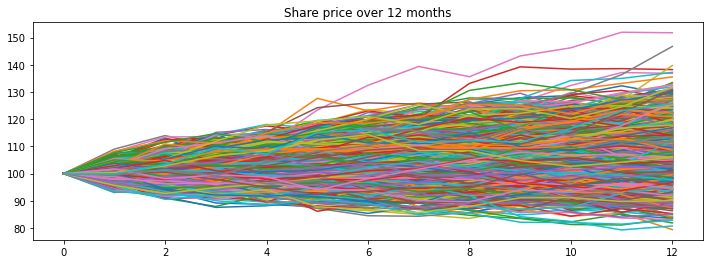

In [25]:
share_prices.iloc[:,0:1000].plot(
    title='Share price over 12 months', 
    legend=False,
    figsize=(12, 4));

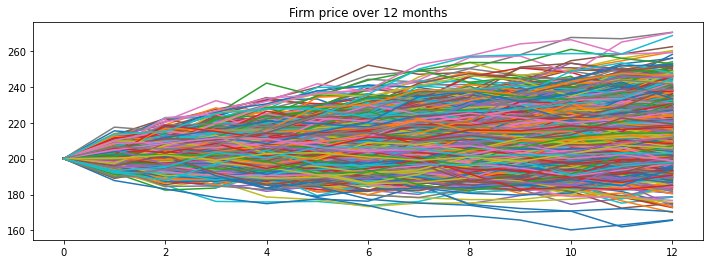

In [26]:
firm_prices.iloc[:,0:1000].plot(
    title='Firm price over 12 months', 
    legend=False,
    figsize=(12, 4));

# Part 2 : Discount Factor and Value of the Up-and-Out Call Option

In this section we use the capitalisation factor calculated in the section above to obtain one-year discount factor. For each simulation - we build firm stock and firm price paths and resolve option payoff to get the final price.

We first calculated the one year discount factor, by inverting the capitalisation factor. The capitalisation factor is calculated by taking the cumulative product of the interest rate between each timestep.

In [27]:
one_year_disc_fac = 1/np.cumprod(1+r_sim,1)[:,-1]
print(one_year_disc_fac)

[0.91951005 0.93197245 0.92761537 ... 0.9176829  0.9345596  0.93167771]


Next, we calculate the default-free option value. \
One difference is that we multiple the payoff by the one year discount factor, instead of multiplying with $e^{rT}$

In [28]:
# define payoff for up-and-out call option
def payoff(S_t, K, L):
    stopped_S = S_t.iloc[-1].where((S_t < L).all(), 0)
    return np.maximum(stopped_S - K, 0).to_numpy()

In [29]:
# Estimate the default-free value of the option:
option_estimate = []
option_std = []

payoffs = payoff(share_prices, K, L)
option_price = one_year_disc_fac*payoffs
print("Simulated option prices: %s" % option_price)
print("Simulated payoffs : %s" % payoffs)

Simulated option prices: [0.82453106 0.         9.54524301 ... 2.48379281 0.         0.67541072]
Simulated payoffs : [ 0.89670695  0.         10.29008721 ...  2.70659157  0.
  0.72494031]


In [30]:
option_estimate = option_price.mean()
option_std = option_price.std()/np.sqrt(sample_size)

print("default-free option price: %.3f" % option_estimate)
print("default-free option price std: %.3f" % option_std)

default-free option price: 8.297
default-free option price std: 0.008


Next, we incorporate the CVA Adjustment similar to the first submission.

In [31]:
payoffs = payoff(share_prices, K, L)
term_firm_vals = firm_prices.iloc[-1].to_numpy()
amount_lost = one_year_disc_fac*(1-recovery_rate)*(term_firm_vals < debt)*payoffs
cva_estimate = amount_lost.mean()
cva_std = amount_lost.std()/np.sqrt(sample_size)

option_cva_price = option_price - amount_lost
option_cva_adjusted_prices = option_cva_price.mean()
option_cva_adjusted_std = option_cva_price.std()/np.sqrt(sample_size)

In [32]:
print("Credit value adjustment: %.3f" % cva_estimate)
print("Credit value adjustment std: %.3f" % cva_std)
print("CVA-adjusted option price: %.3f" % option_cva_adjusted_prices)
print("CVA-adjusted option price std: %.3f" % option_cva_adjusted_std)

Credit value adjustment: 0.017
Credit value adjustment std: 0.000
CVA-adjusted option price: 8.280
CVA-adjusted option price std: 0.008


#  Conclusion

In this paper, we simulated correlated firm and share price paths. we priced an up- and-out call option at 8.303 with a default-free risk profile, and at 8.286 for the CVA-adjusted price. Considering that the same parameters are used as the first submission, where the Black- Scholes-Merton model was used to arrive at a price of 5.697, we observe that both the default risk, the variable interest rate and local volatility have all added a premium to the option price. 

These conditions, which are more aligned to observed market conditions, gave a total increase of 45% over the previously calculated price, with the default risk accounting for only 0.2 of the difference. These results underline the importance of choosing the correct model and performing accurate calibration in order to calculate instrument prices.

#  Reference

[1] Vasicek, O. (1977). An equilibrium characterization of the term structure, Journal of financial economics 5(2): 177-188.

[2] Mamon, R. S. (2004). Three ways to solve for bond prices in the vasicek model, Ad- vances in Decision Sciences 8(1): 1-14.

[3] Hull, J. and White, A. (2001). The general hull-white model and supercalibration, Financial Analysts Journal pp. 34-43.

[4] Cox, J. C., Ingersoll Jr, J. E. and Ross, S. A. (1985). An intertemporal general equi- librium model of asset prices, Econometrica: Journal of the Econometric Society pp. 363-384.

[5] Merton, Robert C. "Theory of rational option pricing." The Bell Journal of economics and management science (1973): 141-183.

[6] Cox, John. "Notes on option pricing I: Constant elasticity of variance diffusions." Unpublished note, Stanford University, Graduate School of Business (1975).

[7] Rich, Don R. "The mathematical foundations of barrier option-pricing theory." Ad- vances in futures and options research 7 (1994).

[8] Wong, Hoi Ying, and YueâARKuen Kwok. "Multi-asset barrier options and occupation time derivatives." Applied Mathematical Finance 10.3 (2003): 245-266.

[9] Black, Fisher, and Myron Scholes. "The pricing and Corportate Liabilities." Journal of Political Economy 81 (1973).

[10] Yousuf, M. "A fourth-order smoothing scheme for pricing barrier options under stochastic volatility." International Journal of Computer Mathematics 86.6 (2009): 1054-1067.

[11] MScFE630 Computational Finance Module 5: Monte Carlo Methods for Risk Management

[12] MScFE630 Computational Finance Module 6: Pricing Interest Rate Options

[13] MScFE630 Computational Finance Module 7: Calibration